In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from random import shuffle
from matplotlib import cm

%matplotlib inline

In [2]:
np.random.seed(101)
error_tab = []
lr_tab = []
acc_tab = []

In [3]:
df = pd.read_csv('tae.data', header=None)

In [4]:
df.head()

,0,1,2,3,4,5
0,1,23,3,1,19,3
1,2,15,3,1,17,3
2,1,23,3,2,49,3
3,1,5,2,2,33,3
4,2,7,11,2,55,3


In [5]:
columns = ['English speaker', 'Course', 'Course instructor', 'Summer or regular semester', 'Class size', 'Class attribute']
df.columns = columns

In [6]:
df.head()

,English speaker,Course,Course instructor,Summer or regular semester,Class size,Class attribute
0,1,23,3,1,19,3
1,2,15,3,1,17,3
2,1,23,3,2,49,3
3,1,5,2,2,33,3
4,2,7,11,2,55,3


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151 entries, 0 to 150
Data columns (total 6 columns):
English speaker               151 non-null int64
Course                        151 non-null int64
Course instructor             151 non-null int64
Summer or regular semester    151 non-null int64
Class size                    151 non-null int64
Class attribute               151 non-null int64
dtypes: int64(6)
memory usage: 7.1 KB


In [8]:
x = df.drop('Class attribute', axis=1).values
labels = df['Class attribute']
y = pd.get_dummies(df['Class attribute']).values

In [9]:
def layer_sizes(X, Y):
    n_x = 5 # input layer
    n_h1 = 50
    n_h2 = 20
    n_y = 3 # output layer
    return (n_x, n_h1, n_h2, n_y)
        
def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    return sigmoid(z)*(1-sigmoid(z))

In [10]:
def initialize_parameters(n_x, n_h1, n_h2, n_y):
    W1 = np.random.randn(n_x,n_h1)
    b1 = np.zeros(n_h1)

    W2 = np.random.randn(n_h1,n_h2)
    b2 = np.zeros(n_h2)

    W3 = np.random.randn(n_h2,n_y)
    b3 = np.zeros(n_y)

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [11]:
def forward_propagation(X, parameters):
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    # Layer 1
    Z1 = np.dot(X, W1) + b1
    A1 = sigmoid(Z1)

    # Layer 2
    Z2 = np.dot(A1, W2) + b2
    A2 = sigmoid(Z2)
    
    # Layer 3
    Z3 = np.dot(A2, W3) + b3
    A3 = sigmoid(Z3)
    
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2,
             "Z3": Z3,
             "A3": A3}
    
    return A3, cache

In [12]:
def compute_cost(A3, Y, parameters):
    m = Y.shape[0] # number of examples
    # cross entropy
    logprobs = np.multiply(np.log(A3), Y) + np.multiply((1 - Y), np.log(1 - A3))
    cost = - np.sum(logprobs) / m    
    
    cost = np.squeeze(cost)
    
    return cost

In [13]:
def backward_propagation(parameters, cache, X, Y):
    """
    Implement the backward propagation using the instructions above.
    
    Arguments:
    parameters -- python dictionary containing our parameters 
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2".
    X -- input data of shape (2, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    
    Returns:
    grads -- python dictionary containing your gradients with respect to different parameters
    """
    
    #  m = X.shape[0]
    # First, retrieve W1 and W2 from the dictionary "parameters".
    W1 = parameters['W1']
    W2 = parameters['W2']
    W3 = parameters['W3']
        
    # Retrieve also A1 and A2 from dictionary "cache".
    A1 = cache['A1']
    A2 = cache['A2']
    A3 = cache['A3']
    
    Z1 = cache['Z1']
    Z2 = cache['Z2']
    '''
    # Backward propagation: calculate dW1, db1, dW2, db2. 
    dZ3 = A3 - Y
    dW3 = (1 / m) * np.dot(A2.T, dZ3)
    db3 = (1 / m) * np.sum(dZ3, axis=1, keepdims=True)
    
    dZ2 = np.multiply(np.dot(dZ3, W3.T), 1 - np.power(A2, 2))
    dW2 = (1 / m) * np.dot(A1.T, dZ2)
    db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)
    
    dZ1 = np.multiply(np.dot(dZ2, W2.T), 1 - np.power(A1, 2))
    dW1 = (1 / m) * np.dot(X.T, dZ1)
    db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)
    
    '''
    
    ########## Layer 3
    delta3 = A3-Y
    dW3 = np.dot(A2.T, delta3)
    db3 = delta3
    
    ########## Layer 2
    delta2 = np.dot(delta3, W3.T) * sigmoid_prime(Z2)
    dW2 = np.dot(A1.T, delta2)
    db2 = delta2
    
    ########## Layer 1
    delta1 = np.dot(delta2, W2.T) * sigmoid_prime(Z1)
    dW1 = np.dot(X.T, delta1)
    db1 = delta1
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2,       
             "dW3": dW3,
             "db3": db3}
    return grads

In [14]:
# update_parameters


def update_parameters(parameters, grads, learning_rate = 0.01):
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']

    dW1 = grads['dW1']
    db1 = grads['db1']
    dW2 = grads['dW2']
    db2 = grads['db2']
    dW3 = grads['dW3']
    db3 = grads['db3']

    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1.sum(axis=0)

    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2.sum(axis=0)
    
    W3 -= learning_rate * dW3
    b3 -= learning_rate * db3.sum(axis=0)
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [15]:
def nn_model(X, Y, n_h1, n_h2, learning_rate = 0.01, num_iterations = 5000, print_cost=True):
    """
    Arguments:
    X -- dataset of shape (2, number of examples)
    Y -- labels of shape (1, number of examples)
    n_h -- size of the hidden layer
    num_iterations -- Number of iterations in gradient descent loop
    print_cost -- if True, print the cost every 1000 iterations
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    np.random.seed(3)
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[3]
    
    # Initialize parameters, then retrieve W1, b1, W2, b2. Inputs: "n_x, n_h, n_y". Outputs = "W1, b1, W2, b2, parameters".
    parameters = initialize_parameters(n_x, n_h1, n_h2, n_y)
    
 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    max_acc = 0;
    
    for epoch in range(0, num_iterations):
         
        # Forward propagation. Inputs: "X, parameters". Outputs: "A2, cache".
        A3, cache = forward_propagation(X, parameters)

        # Cost function. Inputs: "A2, Y, parameters". Outputs: "cost".
        cost = compute_cost(A3, Y, parameters)
 
        # Backpropagation. Inputs: "parameters, cache, X, Y". Outputs: "grads".
        grads = backward_propagation(parameters, cache, X, Y)
 
        # Adaptive learning rate
        learning_rate *= 1/(1 + learning_rate/(epoch+1) * epoch)

        # Gradient descent parameter update. Inputs: "parameters, grads". Outputs: "parameters".
        parameters = update_parameters(parameters, grads, learning_rate)

        if epoch % 200 == 0:
            #loss = -np.sum(y * np.log(A3))
            #error_tab.append(cost)
            #lr_tab.append(learning_rate)
            equals = np.equal(np.argmax(y, axis=1), np.argmax(A3, axis=1))
            acc = np.mean(equals)
            if(acc>max_acc):
                max_acc = acc
            # acc_tab.append(acc)
            # print ("Cost after iteration %i: %f, loss pk: %f, accuracy: %f" %(epoch, cost, loss, acc))

    return parameters, max_acc

In [16]:
# predict

def predict(parameters, X):
    """
    Using the learned parameters, predicts a class for each example in X
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (n_x, m)
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    
    # Computes probabilities using forward propagation, and classifies to 0/1 using 0.5 as the threshold.
    ### START CODE HERE ### (≈ 2 lines of code)
    A3, cache = forward_propagation(X,parameters)
    predictions = A3 # > 0.5
    ### END CODE HERE ###
    
    return predictions

In [17]:
# Build a model with a n_h-dimensional hidden layer
# parameters = nn_model(x, y, n_h1 = 60, n_h2 = 20, learning_rate = 0.01, num_iterations = 10000, print_cost=True)

# plot_decision_boundary(lambda x: predict(parameters, x.T), x, y)
# plt.title("Decision Boundary for hidden layer size " + str(4));

In [18]:
# accuracy plot
# plt.plot(range(len(error_tab)), error_tab)

# print ('Accuracy: %d' % float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100) + '%')

In [19]:
# Create a function called "chunks" with two arguments, l and n:
def chunks(l, n):
    # For item i in a range that is a length of l,
    for i in range(0, len(l), n):
        # Create an index range for l of n items:
        yield l[i:i+n]

In [20]:
# plt.plot(range(len(acc_tab)), acc_tab)

In [21]:
# plt.plot(range(len(lr_tab)), lr_tab)

In [22]:
n_number = list(range(10, 70, 5))
max_acc_array = []
for n_h1 in n_number:
    for n_h2 in n_number:
        parameters, max_acc = nn_model(x, y, n_h1, n_h2, num_iterations = 6000)
        max_acc_array.append(max_acc)
        print("Max accuracy of when 1 layer is {} and sacond layer is {}: {}".format(n_h1, n_h2, max_acc))


Max accuracy of when 1 layer is 10 and sacond layer is 10: 0.4370860927152318
Max accuracy of when 1 layer is 10 and sacond layer is 15: 0.40397350993377484
Max accuracy of when 1 layer is 10 and sacond layer is 20: 0.5165562913907285
Max accuracy of when 1 layer is 10 and sacond layer is 25: 0.5298013245033113
Max accuracy of when 1 layer is 10 and sacond layer is 30: 0.40397350993377484
Max accuracy of when 1 layer is 10 and sacond layer is 35: 0.5165562913907285
Max accuracy of when 1 layer is 10 and sacond layer is 40: 0.543046357615894
Max accuracy of when 1 layer is 10 and sacond layer is 45: 0.609271523178808
Max accuracy of when 1 layer is 10 and sacond layer is 50: 0.46357615894039733
Max accuracy of when 1 layer is 10 and sacond layer is 55: 0.40397350993377484
Max accuracy of when 1 layer is 10 and sacond layer is 60: 0.4105960264900662
Max accuracy of when 1 layer is 10 and sacond layer is 65: 0.4966887417218543
Max accuracy of when 1 layer is 15 and sacond layer is 10: 0.6

Max accuracy of when 1 layer is 50 and sacond layer is 60: 0.6754966887417219
Max accuracy of when 1 layer is 50 and sacond layer is 65: 0.6622516556291391
Max accuracy of when 1 layer is 55 and sacond layer is 10: 0.8079470198675497
Max accuracy of when 1 layer is 55 and sacond layer is 15: 0.8013245033112583
Max accuracy of when 1 layer is 55 and sacond layer is 20: 0.7549668874172185
Max accuracy of when 1 layer is 55 and sacond layer is 25: 0.7350993377483444
Max accuracy of when 1 layer is 55 and sacond layer is 30: 0.7417218543046358
Max accuracy of when 1 layer is 55 and sacond layer is 35: 0.5960264900662252
Max accuracy of when 1 layer is 55 and sacond layer is 40: 0.6556291390728477
Max accuracy of when 1 layer is 55 and sacond layer is 45: 0.7615894039735099
Max accuracy of when 1 layer is 55 and sacond layer is 50: 0.7748344370860927
Max accuracy of when 1 layer is 55 and sacond layer is 55: 0.6622516556291391
Max accuracy of when 1 layer is 55 and sacond layer is 60: 0.721

In [23]:
max_acc_array = list(chunks(max_acc_array, len(n_number)))
max_acc_array = np.array(max_acc_array)

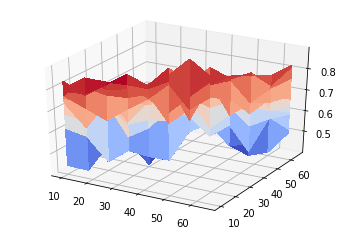

In [24]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(n_number, n_number, max_acc_array, rstride=1, cstride=1, cmap=cm.coolwarm,
    linewidth=0, antialiased=False)

In [25]:
print(np.amax(max_acc_array))

0.8874172185430463
